In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from concorde.tools import from_mag_to_uv, stormDir, forwardSpeed, geoDistKM
from shapely.geometry import Point
import geopandas as gpd
from tqdm import tqdm as tqdm
import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = Path(r'../data/probabilisticPredictions')

In [3]:
## this data has the tides predicted by NOAA
dctTracks = pd.read_pickle(path/'tracksNC_with100perturbations_predTides_processed.pkl')

In [5]:
dctTidesADCIRC = pd.read_pickle(r'../models/adcirc/concorde/batch02/_postprocessing/time_series_water_level_historicStorms_tideSim.pkl')

#### Compare tides

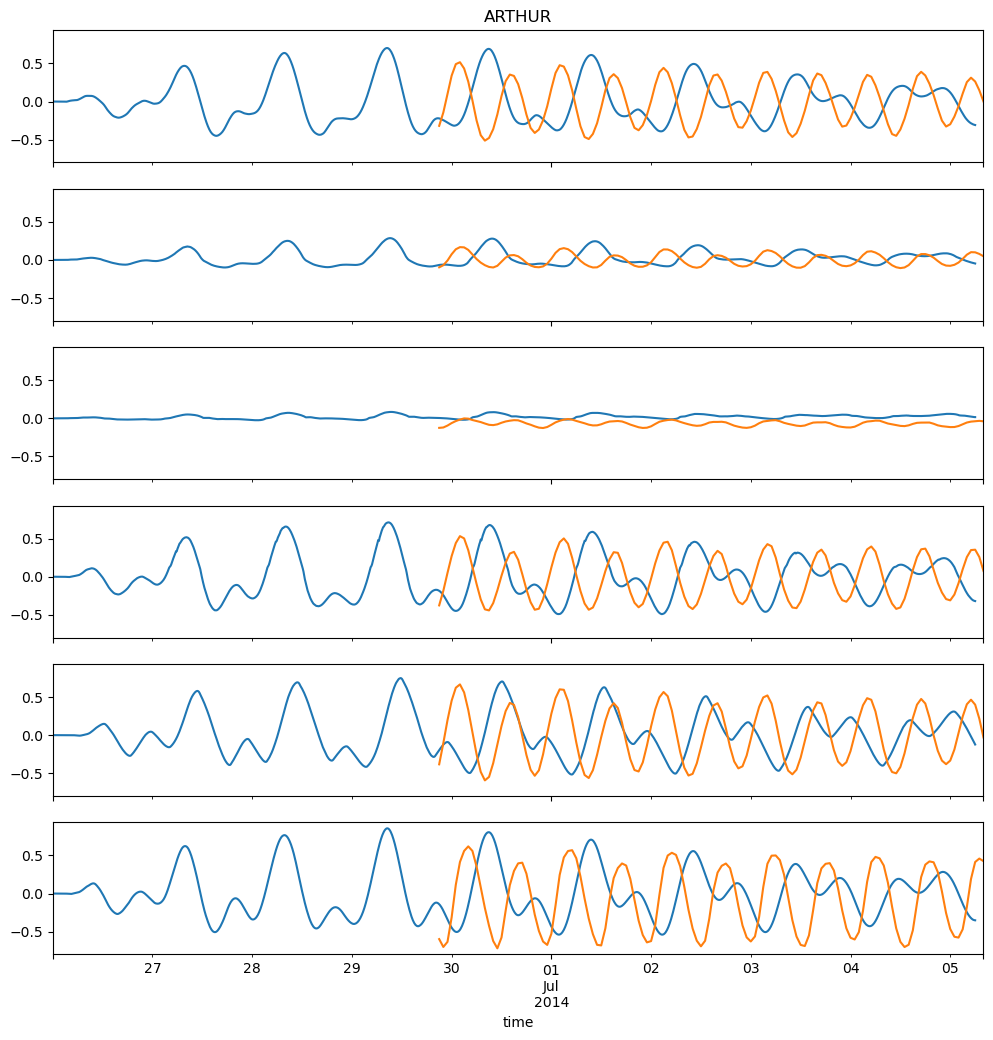

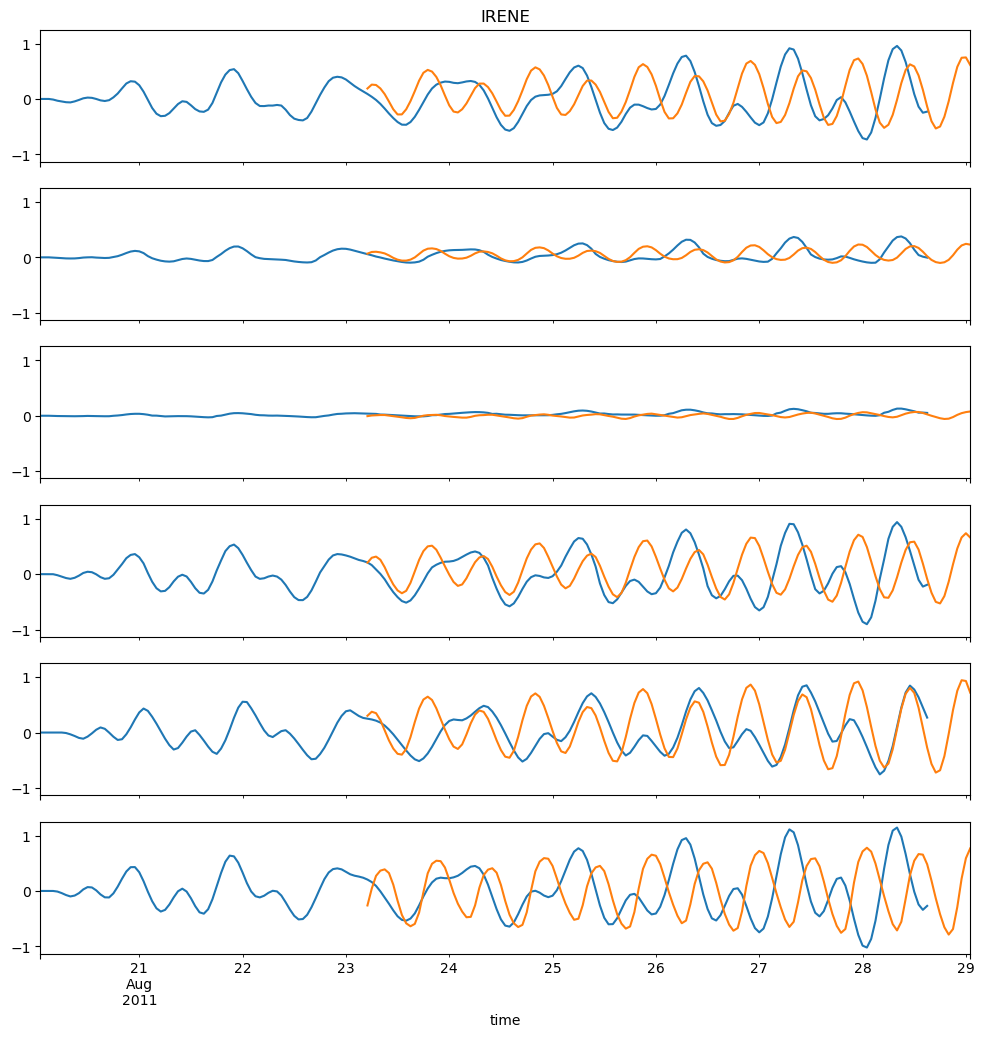

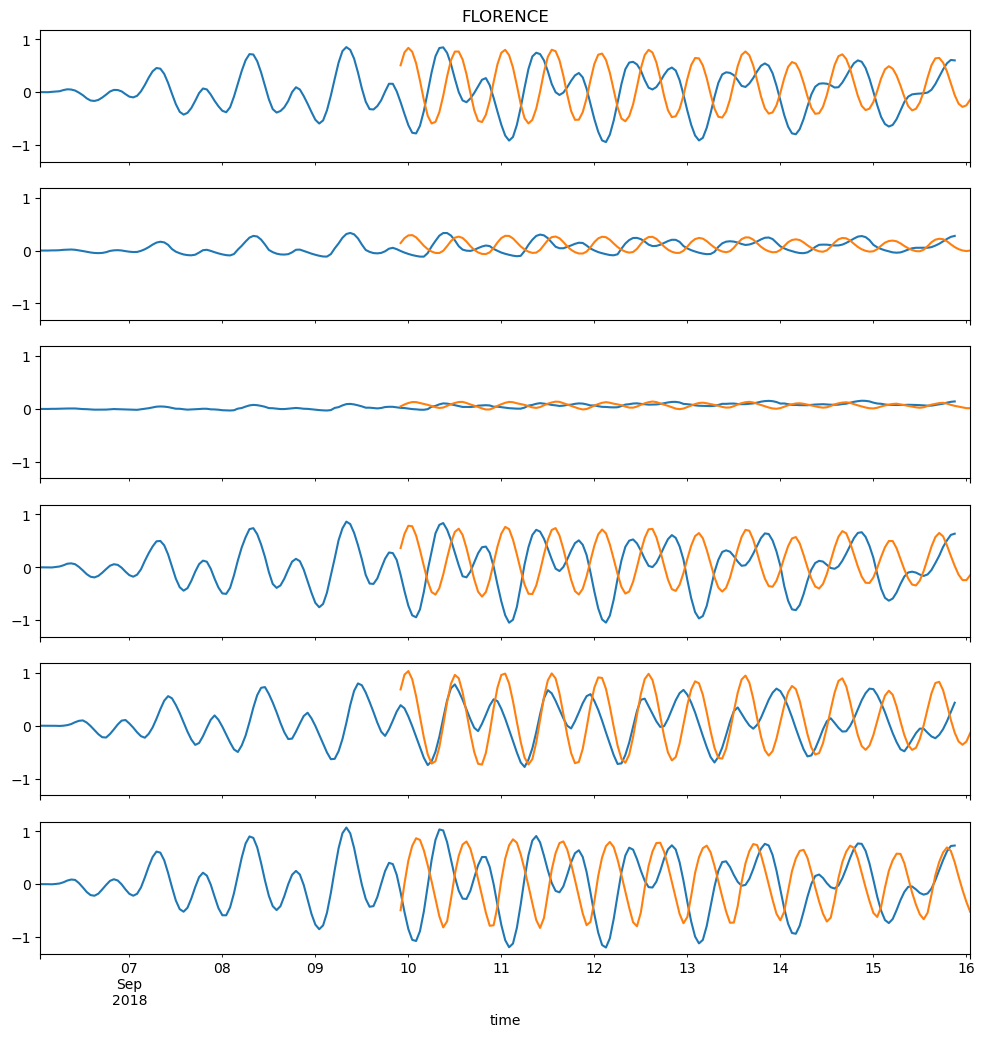

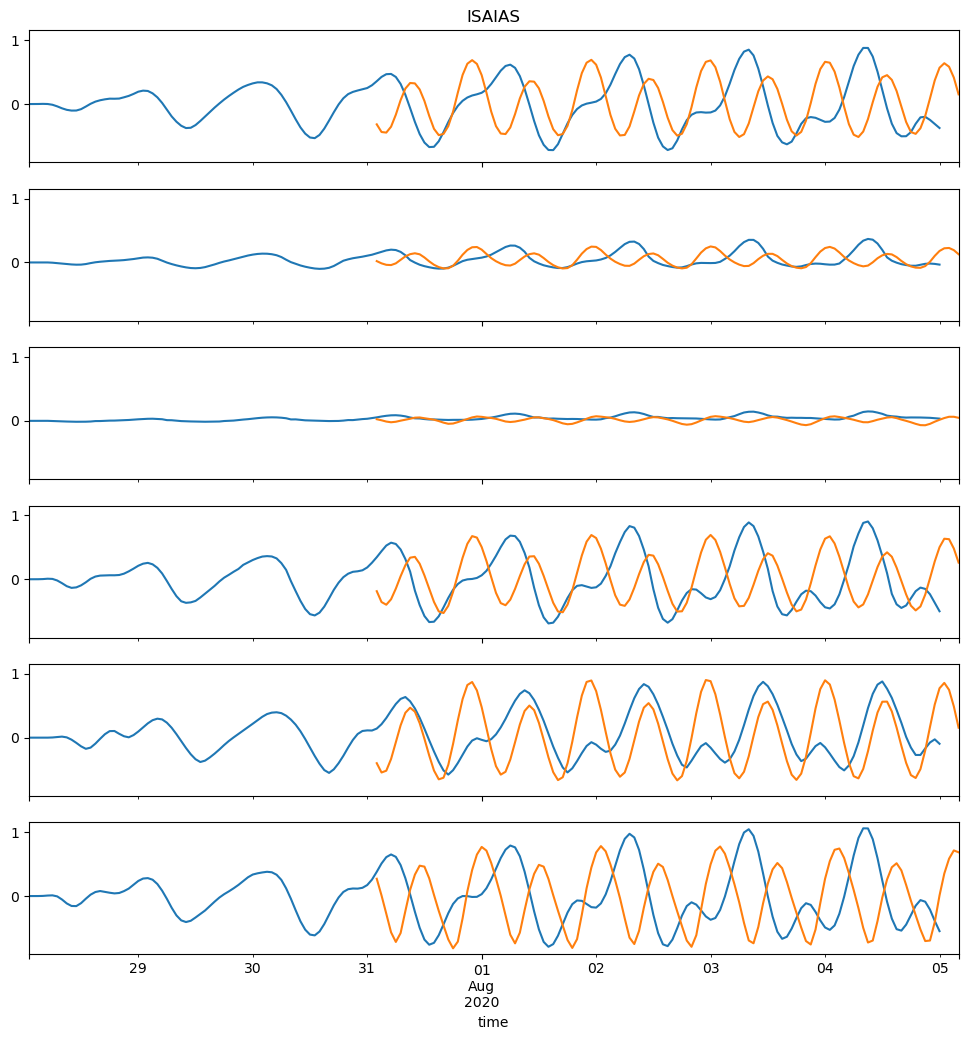

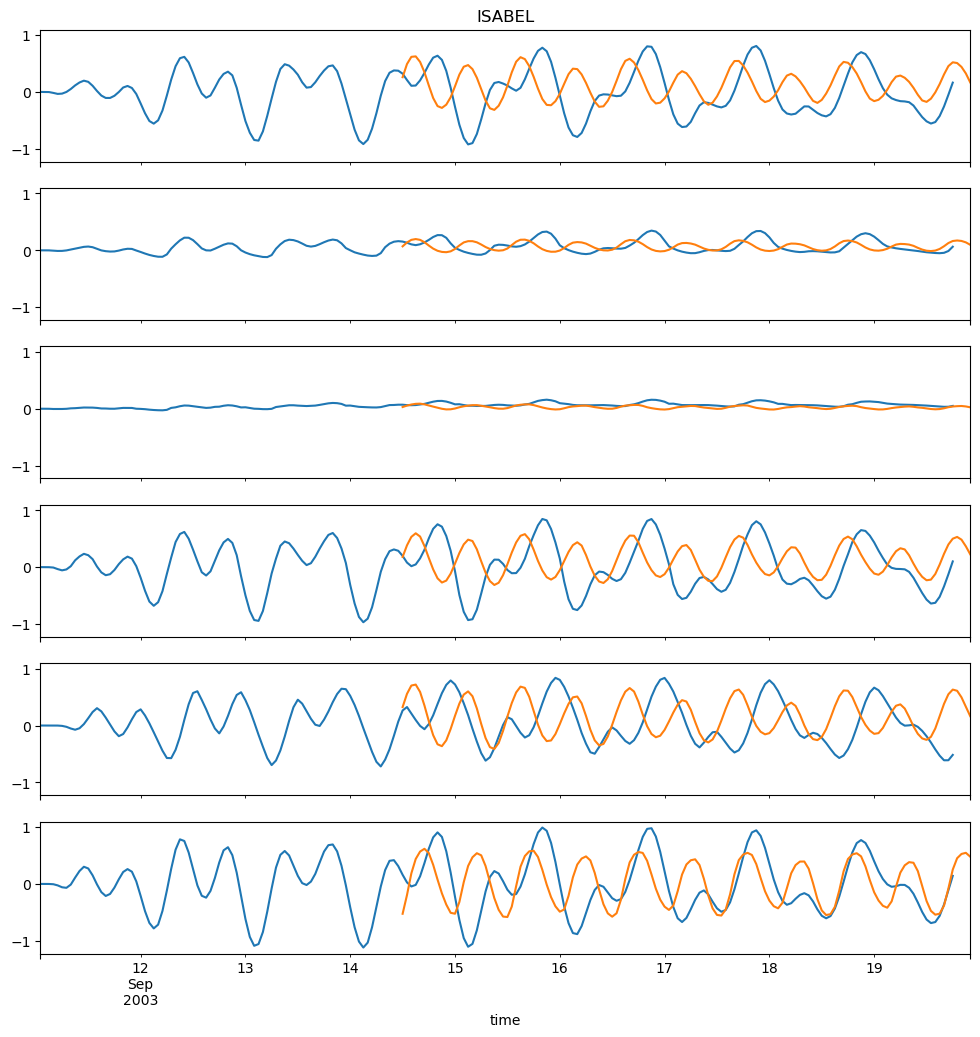

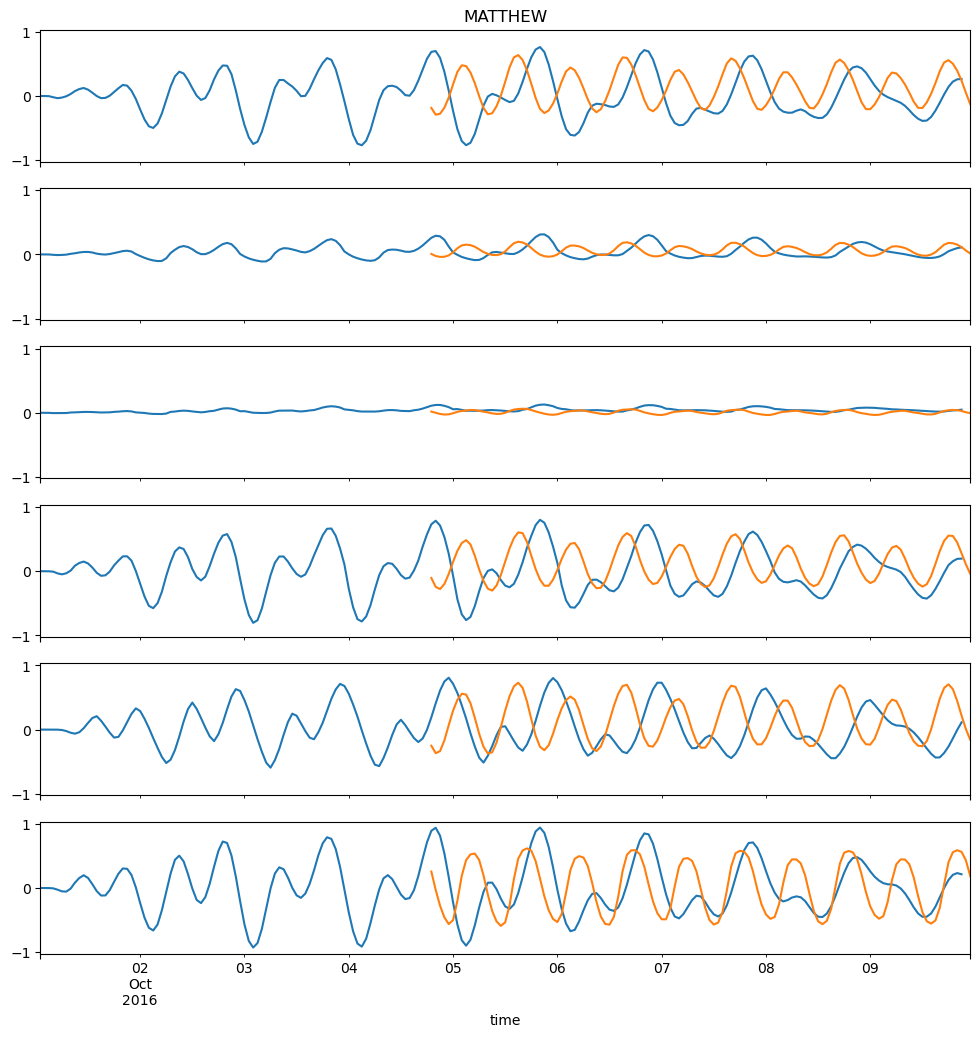

In [8]:
for k in dctTidesADCIRC:
    fig, ax = plt.subplots(figsize = (12, 12), nrows = 6, sharex = True, sharey = True)
    for i in range(6):
        dctTidesADCIRC[k].iloc[:, i].plot(ax = ax[i])
        dctTracks[f"{k.split('_')[0]}_pert000"].iloc[:, 15+i].plot(ax = ax[i])
    ax[0].set_title(k.split('_')[0])

#### Replace NOAA predicted tides with ADCIRC

In [47]:
dctTracksProcess = {}
for k in dctTidesADCIRC.keys():
    storm = k.split('_')[0]
    aux0 = dctTidesADCIRC[k].resample('1H').mean().tz_localize(None)
    aux1 = aux0.loc[aux0.index.isin(dctTracks[f'{storm}_pert000'].index), :]
    for i in range(100):
        aux2 = dctTracks[f'{storm}_pert{i:03d}'].loc[aux1.index, :]
        ## tides 6 statios and boundary are in columns 15 to 21
        aux3 = aux2.copy()
        aux3.iloc[:,15:22] = aux1.values
        dctTracksProcess[f'{storm}_pert{i:03d}'] = aux3

with open(path/'tracksNC_with100perturbations_ADCIRCTides_processed.pkl', 'wb') as fout:
    pickle.dump(dctTracksProcess, fout)

#### Apply zero padding to match training dataset dimensions

In [50]:
## zero padding data

maxlen = 235

with open(path/'tracksNC_with100perturbations_ADCIRCTides_processed.pkl', 'rb') as fin:
    dctTracksProcessed = pickle.load(fin)

inpArrPadded = []
for k in dctTracksProcessed.keys():
    aux = dctTracksProcessed[k]
    padLength = maxlen - len(aux)
    auxPadded = np.pad(aux.values, ((padLength, 0), (0, 0)), mode = 'constant')
    inpArrPadded.append(auxPadded)

inpArrPadded = np.asarray(inpArrPadded, dtype = float)
np.save(path/f'tracksNCshortened_with100perturbations_ADCIRCTides_processed_zeroPadded.npy', inpArrPadded, allow_pickle=False)

In [51]:
### scale data
inpArray = np.load(path/f'tracksNCshortened_with100perturbations_predTides_processed_zeroPadded.npy')
pathinScaler = Path(r'../models/NNmodel/inputs/random_split')
scaler = pickle.load(open(pathinScaler/'standarScaler_augmentedAllX50_def.pkl', 'rb'))

inpArray_res = inpArray.reshape(inpArray.shape[0] * inpArray.shape[1], inpArray.shape[2])
mask = inpArray_res == 0
inpArray_res[mask] = np.nan
inpArray_res_sc = scaler.transform(inpArray_res)
inpArray_res_sc = np.nan_to_num(inpArray_res_sc, nan=-9999)
inpArray_sc = inpArray_res_sc.reshape(inpArray.shape)
print(inpArray_sc.shape)
np.save(path/f'tracksNCshortened_with100perturbations_ADCIRCTides_processed_zeroPadded_scaled.npy', inpArray_sc, allow_pickle=False)

(700, 235, 37)
